# Import libraries

In [9]:
!pip install wordcloud

     ------------------------------------ 153.1/153.1 kB 228.5 kB/s eta 0:00:00


In [85]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from keras.models import load_model
from sklearn.model_selection import train_test_split
from keras.layers import Embedding, Concatenate, Dense, Flatten, Input
from keras.models import Model
from wordcloud import WordCloud
warnings.filterwarnings('ignore')
%matplotlib inline


In [120]:
# Load each data set (users, movies, and ratings).
users_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('ml-100k/u.user', sep='|', names=users_cols )
ratings_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=ratings_cols)
users.head(),ratings.head()

(   user_id  age sex  occupation zip_code
 0        1   24   M  technician    85711
 1        2   53   F       other    94043
 2        3   23   M      writer    32067
 3        4   24   M  technician    43537
 4        5   33   F       other    15213,
    user_id  movie_id  rating  unix_timestamp
 0      196       242       3       881250949
 1      186       302       3       891717742
 2       22       377       1       878887116
 3      244        51       2       880606923
 4      166       346       1       886397596)

In [93]:
# The movies file contains a binary feature for each genre.
genre_cols = [
    "genre_unknown", "Action", "Adventure", "Animation", "Children", "Comedy",
    "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror",
    "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"
]
movies_cols = [
    'movie_id', 'title', 'release_date', "video_release_date", "imdb_url"
] + genre_cols

movies = pd.read_csv(
    'ml-100k/u.item', sep='|', names=movies_cols)

# make ids start from 0
users["user_id"] = users["user_id"].apply(lambda x: int(x-1))

movies["movie_id"] = movies["movie_id"].apply(lambda x: int(x-1))

movies["year"] = movies['release_date'].apply(lambda x: str(x).split('-')[-1])

ratings["movie_id"] = ratings["movie_id"].apply(lambda x: int(x-1))

ratings["user_id"] = ratings["user_id"].apply(lambda x: int(x-1))

ratings["rating"] = ratings["rating"].apply(lambda x: float(x))

In [94]:
dataset = ratings.merge(movies, on='movie_id').merge(users, on='user_id')

In [116]:
dataset.head(10)

,user_id,movie_id,rating,unix_timestamp,title,release_date,video_release_date,imdb_url,genre_unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year,age,sex,occupation,zip_code
0,195,241,3.0,881250949,Kolya (1996),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1997,49,M,writer,55105
1,195,256,2.0,881251577,Men in Black (1997),04-Jul-1997,NaN,http://us.imdb.com/M/title-exact?Men+in+Black+...,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1997,49,M,writer,55105
2,195,110,4.0,881251793,"Truth About Cats & Dogs, The (1996)",26-Apr-1996,NaN,http://us.imdb.com/M/title-exact?Truth%20About...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1996,49,M,writer,55105
3,195,24,4.0,881251955,"Birdcage, The (1996)",08-Mar-1996,NaN,"http://us.imdb.com/M/title-exact?Birdcage,%20T...",0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1996,49,M,writer,55105
4,195,381,4.0,881251843,"Adventures of Priscilla, Queen of the Desert, ...",01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Adventures%20...,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1994,49,M,writer,55105
5,195,201,3.0,881251728,Groundhog Day (1993),01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Groundhog%20D...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1993,49,M,writer,55105
6,195,152,5.0,881251820,"Fish Called Wanda, A (1988)",01-Jan-1988,NaN,http://us.imdb.com/M/title-exact?Fish%20Called...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1988,49,M,writer,55105
7,195,285,5.0,881250949,"English Patient, The (1996)",15-Nov-1996,NaN,http://us.imdb.com/M/title-exact?English%20Pat...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1996,49,M,writer,55105
8,195,65,3.0,881251911,While You Were Sleeping (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?While%20You%2...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1995,49,M,writer,55105
9,195,844,4.0,881251954,That Thing You Do! (1996),28-Sep-1996,NaN,http://us.imdb.com/M/title-exact?That%20Thing%...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1996,49,M,writer,55105


# Data Visualization

In [121]:

            
genres = str(genre_cols)

movie_titles = []

for mv in dataset.title:
    movie_titles.append(mv)
    
movie_titles = str(movie_titles)
    
        

## wordcloud

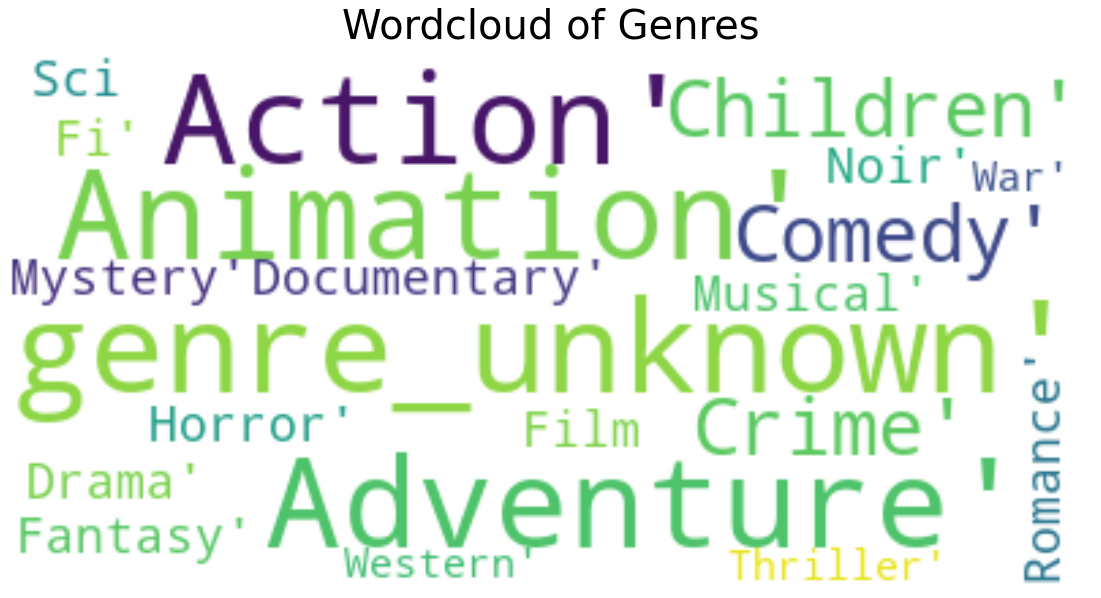

In [122]:
wordcloud_genres = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(genres)
plt.figure(figsize=(30,10))
plt.imshow(wordcloud_genres, interpolation='bilinear')
plt.axis('off')
plt.title("Wordcloud of Genres", fontsize=40)
plt.show()

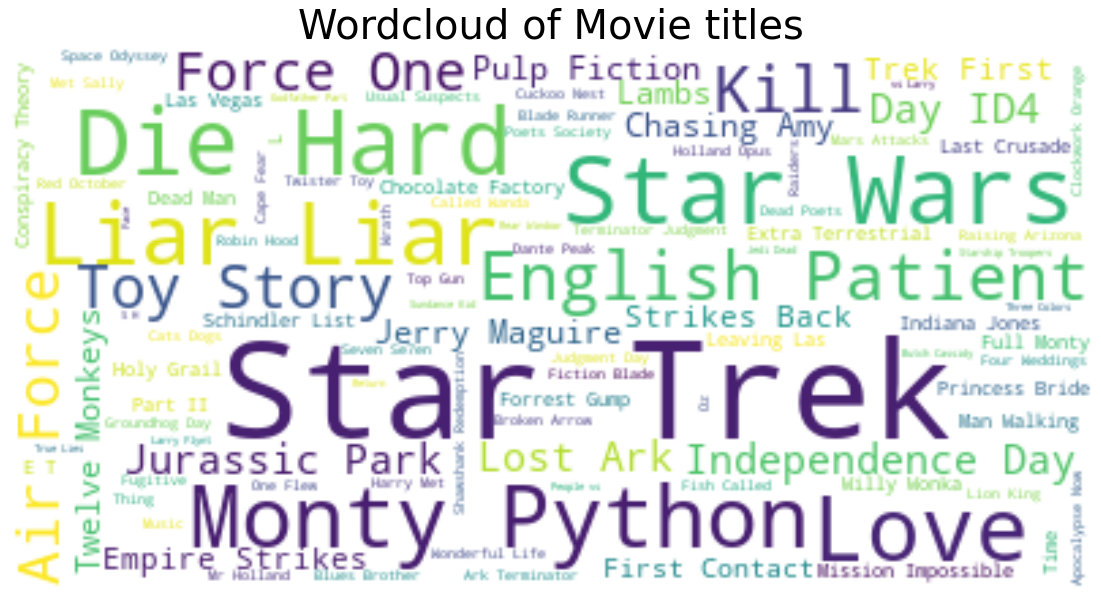

In [123]:
wordcloud_genres = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(movie_titles )
plt.figure(figsize=(30,10))
plt.imshow(wordcloud_genres, interpolation='bilinear')
plt.axis('off')
plt.title("Wordcloud of Movie titles", fontsize=40)
plt.show()

In [126]:
top_rated = dataset.groupby(['title'])[['rating']].sum().nlargest(20,'rating')
top_rated.head()

,rating
title,
Star Wars (1977),2541.0
Fargo (1996),2111.0
Return of the Jedi (1983),2032.0
Contact (1997),1936.0
Raiders of the Lost Ark (1981),1786.0


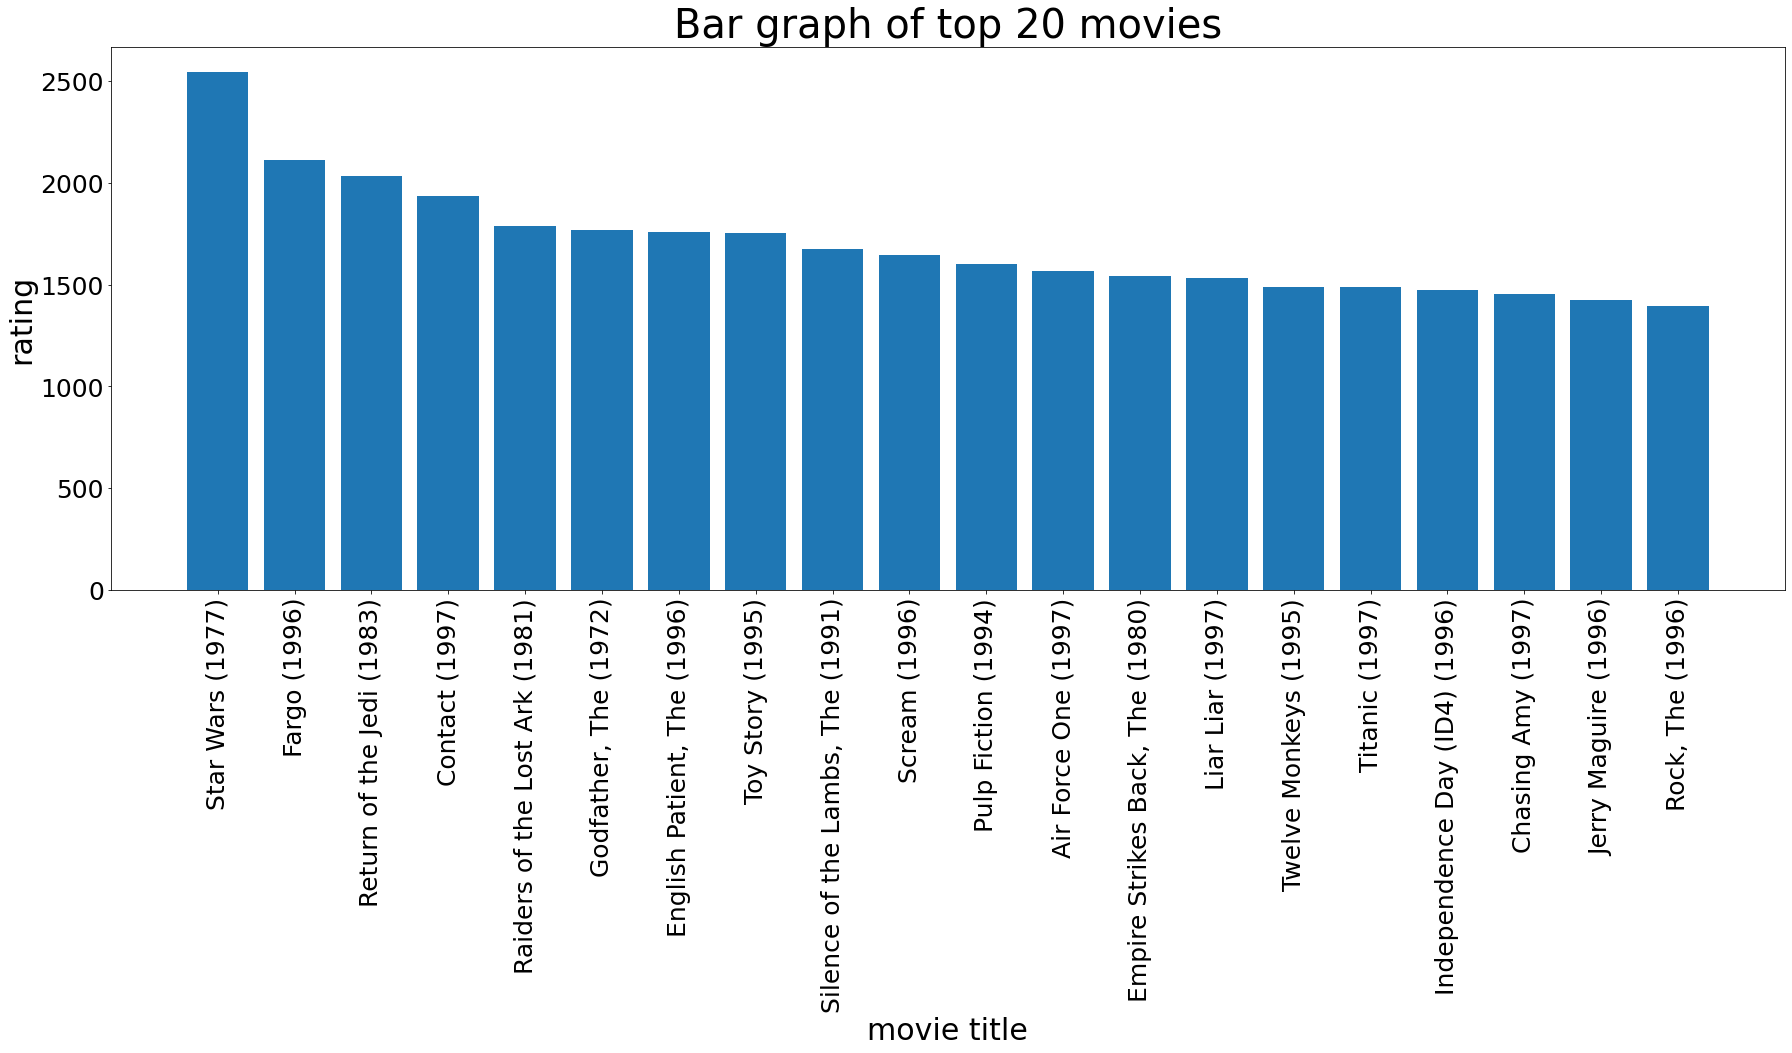

In [128]:
plt.figure(figsize=(30,10))
plt.title("Bar graph of top 20 movies", fontsize=40)
plt.xlabel('movie title', fontsize= 30)
plt.xticks(fontsize=25, rotation=90)
plt.yticks(fontsize=25)
plt.ylabel('rating', fontsize=30)
plt.bar(top_rated.index,top_rated['rating'],linewidth=3)
plt.show()

# split the dataset

In [129]:
#10% used for testing
train,test = train_test_split(dataset, test_size=0.1, random_state=42)

In [130]:
ROW_COUNT = train.shape[0]
EMBEDDING_SIZE = 10
NUM_USERS = dataset['user_id'].nunique()
NUM_MOVIES = dataset['movie_id'].nunique()
UNIQUE_MOVIE_IDS = dataset['movie_id'].unique()

NUM_MOVIES, ROW_COUNT

(1682, 90000)

# Neural Network Model

## Emdedding layer function

In [131]:
def EmbeddingRec(EMBEDDING_SIZE, NUM_MOVIES, NUM_USERS, ROW_COUNT):
    
    movie_input = keras.Input(shape=(1,), name='movie_id')

    movie_emb = layers.Embedding(output_dim=EMBEDDING_SIZE, input_dim=NUM_MOVIES, input_length=ROW_COUNT, name='movie_emb')(movie_input)
    movie_vec = layers.Flatten(name='FlattenMovie')(movie_emb)

    movie_model = keras.Model(inputs=movie_input, outputs=movie_vec)
    
    user_input = keras.Input(shape=(1,), name='user_id')

    user_emb = layers.Embedding(output_dim=EMBEDDING_SIZE, input_dim=NUM_USERS, input_length=ROW_COUNT, name='user_emb')(user_input)
    user_vec = layers.Flatten(name='FlattenUser')(user_emb)

    user_model = keras.Model(inputs=user_input, outputs=user_vec)
    
    merged = layers.Dot(name = 'dot_product', normalize = True, axes = 2)([movie_emb, user_emb])
    merged_dropout = layers.Dropout(0.2)(merged)
    
    
    dense_1 = layers.Dense(70,name='FullyConnected-1')(merged)
    dropout_1 = layers.Dropout(0.2,name='Dropout_1')(dense_1)

    dense_2 = layers.Dense(50,name='FullyConnected-2')(dropout_1)
    dropout_2 = layers.Dropout(0.2,name='Dropout_2')(dense_2)

    dense_3 = keras.layers.Dense(20,name='FullyConnected-3')(dropout_2)
    dropout_3 = keras.layers.Dropout(0.2,name='Dropout_3')(dense_3)

    dense_4 = keras.layers.Dense(10,name='FullyConnected-4', activation='relu')(dropout_3)

    result = layers.Dense(1, name='result', activation="relu") (dense_4)

    adam = keras.optimizers.Adam(lr=0.001)
    model = keras.Model([movie_input, user_input], result)
    model.compile(optimizer=adam,loss= 'mean_absolute_error')
    return model, movie_model, user_model

In [132]:
model, movie_model, user_model = EmbeddingRec(EMBEDDING_SIZE, NUM_MOVIES, NUM_USERS, ROW_COUNT)

# Fit the model with data

In [133]:
callbacks = [keras.callbacks.EarlyStopping('val_loss', patience=10),
             keras.callbacks.ModelCheckpoint('best.h5', save_best_only=True)]

history = model.fit([train.movie_id, train.user_id],train.rating, batch_size=100,
                              epochs =50, validation_data = ([test.movie_id, test.user_id],test.rating),
                              verbose = 1, 
                              callbacks = callbacks)

Epoch 1/50
900/900 [==============================] - 4s 3ms/step - loss: 1.0577 - val_loss: 0.9469
Epoch 2/50
900/900 [==============================] - 2s 2ms/step - loss: 0.9466 - val_loss: 0.9580
Epoch 3/50
900/900 [==============================] - 2s 2ms/step - loss: 0.9299 - val_loss: 0.9420
Epoch 4/50
900/900 [==============================] - 2s 2ms/step - loss: 0.8745 - val_loss: 0.8214
Epoch 5/50
900/900 [==============================] - 2s 2ms/step - loss: 0.7452 - val_loss: 0.7860
Epoch 6/50
900/900 [==============================] - 2s 2ms/step - loss: 0.6964 - val_loss: 0.7777 - ETA: 0s - los - ETA: 0s - los
Epoch 7/50
900/900 [==============================] - 2s 2ms/step - loss: 0.6685 - val_loss: 0.7843
Epoch 8/50
900/900 [==============================] - 2s 2ms/step - loss: 0.6513 - val_loss: 0.7911
Epoch 9/50
900/900 [==============================] - 2s 2ms/step - loss: 0.6392 - val_loss: 0.7787
Epoch 10/50
900/900 [==============================] - 2s 2ms/step -

In [134]:
history.history

{'loss': [1.057653784751892,
  0.94663405418396,
  0.9298964142799377,
  0.8744683265686035,
  0.7451980113983154,
  0.6964099407196045,
  0.6685073375701904,
  0.651333749294281,
  0.6391761898994446,
  0.6297069191932678,
  0.6204113364219666,
  0.6137025356292725,
  0.607177197933197,
  0.6027529835700989,
  0.5979923009872437,
  0.5954673886299133,
  0.5910789370536804,
  0.5886938571929932,
  0.5857539176940918,
  0.5845187306404114,
  0.5817986130714417,
  0.5798134803771973,
  0.5772992968559265,
  0.5751597881317139,
  0.5747649073600769,
  0.5725561380386353,
  0.5705294013023376,
  0.5693534016609192,
  0.5664916038513184,
  0.5655994415283203,
  0.5653968453407288,
  0.5640047788619995,
  0.5629786252975464,
  0.5612816214561462],
 'val_loss': [0.9469091892242432,
  0.9579827189445496,
  0.9419935345649719,
  0.8213950395584106,
  0.7860121130943298,
  0.777682363986969,
  0.7842894792556763,
  0.7911468148231506,
  0.7786877155303955,
  0.7807410955429077,
  0.7943692803382

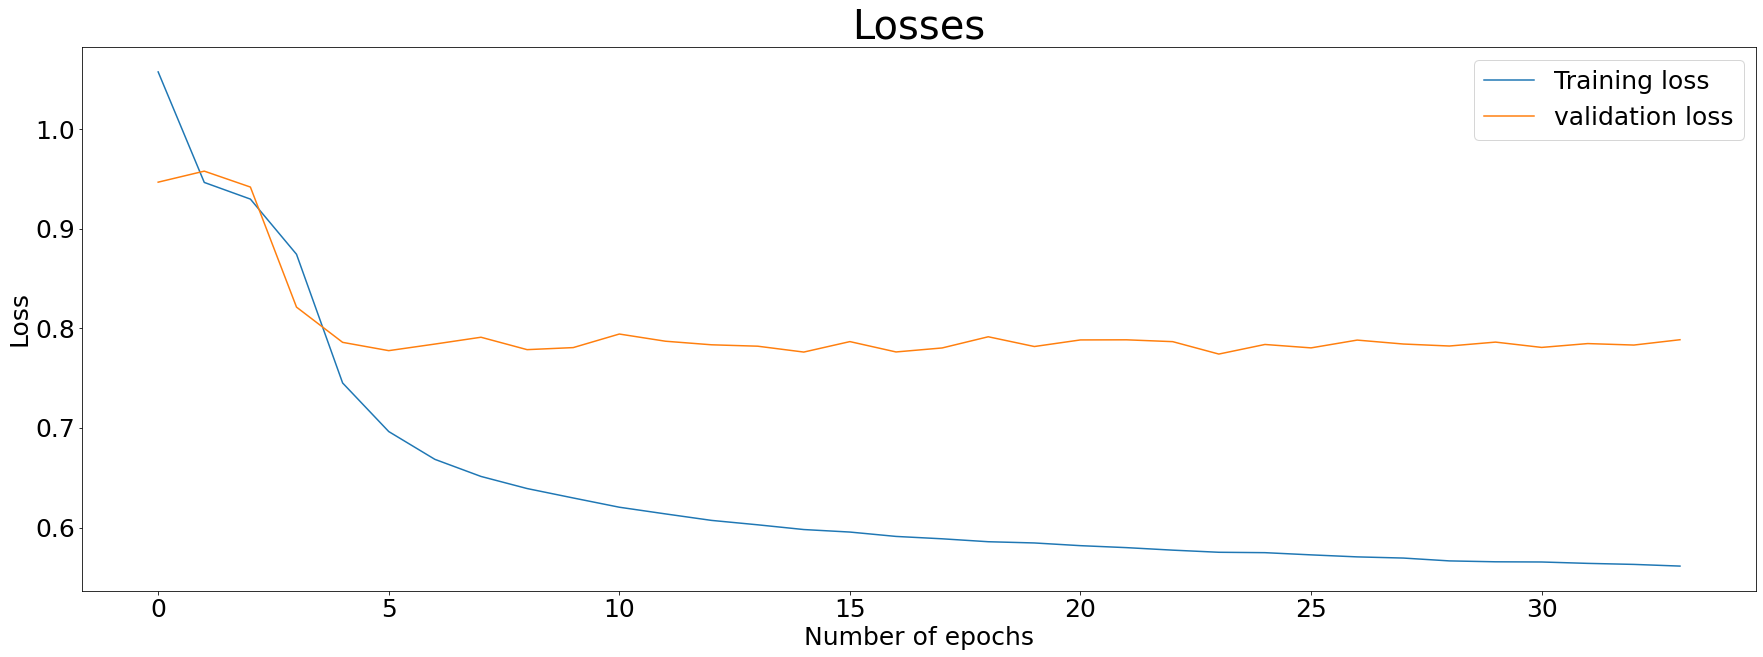

In [137]:
# plot training and validation loss
plt.figure(figsize=(30,10))
plt.title('Losses', fontsize=40)
plt.xlabel('Number of epochs',fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.ylabel('Loss',fontsize=25)
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend(fontsize=25)
plt.show()

In [138]:
import collections
MOVIE_EMBEDDING_LIST = []
MOVIE_EMBED_MAP = collections.defaultdict()
MOVIE_EMBED_MAP

defaultdict(None, {})

In [139]:
for _id in UNIQUE_MOVIE_IDS:
    emb = movie_model.predict(np.array([_id]))
    val = list(emb.reshape(1,-1))[0]
    MOVIE_EMBEDDING_LIST.insert(_id, val)
    MOVIE_EMBED_MAP[_id] = val

# USing K-Nearest Neighbors to recommend movies 

In [140]:
knn_train_label = UNIQUE_MOVIE_IDS

In [141]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=15)
clf.fit(MOVIE_EMBEDDING_LIST, knn_train_label)

KNeighborsClassifier(n_neighbors=15)

In [142]:
def recommend_movies(embedding):
    distances, indices = clf.kneighbors(embedding.reshape(1, -1),  n_neighbors=15)
    indices = indices.reshape(15,1)
    df_indices = pd.DataFrame(indices, columns = ['movie_id'])
    return df_indices.merge(movies,on='movie_id',how='inner',suffixes=['_u', '_m'])['title']

In [143]:
user_embedding = user_model.predict([220]).reshape(1,-1)[0]

In [144]:
recommend_movies(user_embedding)

0             Somewhere in Time (1980)
1                Get on the Bus (1996)
2                    Phat Beach (1996)
3                     No Escape (1994)
4      Midnight Dancers (Sibak) (1994)
5         Life Less Ordinary, A (1997)
6           Singin' in the Rain (1952)
7                  Mad Dog Time (1996)
8                  Wild America (1997)
9                      Faithful (1996)
10             King of New York (1990)
11                     Deceiver (1997)
12                    Dream Man (1995)
13    Ayn Rand: A Sense of Life (1997)
14                     Van, The (1996)
Name: title, dtype: object